# Estudo de Caso Petlove: Análise de Churn

Procuramos nesta análise traçar um perfil descritivo dos clientes que cancelaram suas assinaturas na PetLove

In [1]:
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
file = 'data-test-analytics.csv'

df = pd.read_csv(file)

In [3]:
#descricao das colunas 
explain = {
    "id" : "Identificação do cliente",
    "created_at" : "Data de criação da assinatura",
    "updated_at" : "Data da última modificação da assinatura",
    "deleted_at" : "Data de cancelamento da assinatura",
    "name_hash" : "Nome do usuário (criptografado)",
    "email_hash" : "Email (criptografado)",
    "address_hash" : "Endereço (criptografado)",
    "birth_date" : "Data de aniversário do cliente",
    "status" : "Status da assinatura",
    "version" : "Versão da assinatura",
    "city" : "Cidade do cliente",
    "state" : "Estado do cliente",
    "neighborhood" : "Bairro do cliente",
    "last_date_purchase" : "Data do último pedido que ocorreu pela assinatura",
    "average_ticket" : "Média de gasto por pedido",
    "items_quantity" : "Média de itens na assinatura",
    "all_revenue" : "Total de receita realizado pelo cliente",
    "all_orders" : "Total de pedidos realizado pelo cliente",
    "recency" : "Tempo desde a última compra do cliente",
    "marketing_source" : "Canal de marketing que converteu a assinatura"    
}

In [4]:
df.head(1)

,id,created_at,updated_at,deleted_at,name_hash,email_hash,address_hash,birth_date,status,version,city,state,neighborhood,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source
0,8bf7960e-3b93-468b-856e-6c6c5b56f52b,08/15/17 07:05 AM,01/14/21 11:23 AM,NaN,312d206168a318614897e8ccac43bff9,83eb3aed9a44377df80ce876dce92c9a,8b4bfaa0cbc41a16f46da15ddcd6a907,07/10/74 12:00 AM,active,2.31.7,Peixoto da Praia,AM,Aparecida 7ª Seção,01/14/21 11:23 AM,151.142942,10,906.857651,6,35,crm


In [5]:
#removendo colunas
df_config = df.copy()
del df_config['name_hash']
del df_config['email_hash']
del df_config['address_hash']
del df_config['version']
del df_config['id']
del df_config['city']
del df_config['neighborhood']
del df_config['birth_date']
df_config.head(1)

,created_at,updated_at,deleted_at,status,state,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source
0,08/15/17 07:05 AM,01/14/21 11:23 AM,NaN,active,AM,01/14/21 11:23 AM,151.142942,10,906.857651,6,35,crm


In [6]:
#transformando as colunos com datas de str -> datetime
df_config['created_at'] = pd.to_datetime(df_config['created_at'])
df_config['deleted_at'] = pd.to_datetime(df_config['deleted_at'])
df_config['updated_at'] = pd.to_datetime(df_config['updated_at'])
df_config['last_date_purchase'] = pd.to_datetime(df_config['last_date_purchase'])

In [7]:
columns_rename = {'birth_date':'nascimento', 'state':'estado', 'last_date_purchase':'ultima_compra', 'average_ticket':'gasto_medio', 
                 'items_quantity':'quantidade_media', 'all_revenue':'receita', 'all_orders':'pedidos', 'marketing_source':'canal_marketing'}
df_config.rename(columns = columns_rename, inplace = True)

In [8]:
df_config.head(1)

,created_at,updated_at,deleted_at,status,estado,ultima_compra,gasto_medio,quantidade_media,receita,pedidos,recency,canal_marketing
0,2017-08-15 07:05:00,2021-01-14 11:23:00,NaT,active,AM,2021-01-14 11:23:00,151.142942,10,906.857651,6,35,crm


# Adicionando informações

In [9]:
#forma do dataset
df_config.shape

(10000, 12)

In [10]:
#adicionando a informacao de Churn, onde foi considerado somente Churn os clientes com status == canceled
churn = []
for i in df['status'].tolist():
    if(i == 'canceled'):
        churn.append('Yes')
    else:
        churn.append('No')
df_config['Churn'] = churn

text_label = LabelEncoder()
df_config['Churn'] = text_label.fit_transform(df_config.Churn)

df_config.head(1)

,created_at,updated_at,deleted_at,status,estado,ultima_compra,gasto_medio,quantidade_media,receita,pedidos,recency,canal_marketing,Churn
0,2017-08-15 07:05:00,2021-01-14 11:23:00,NaT,active,AM,2021-01-14 11:23:00,151.142942,10,906.857651,6,35,crm,0


In [11]:
#adicionando tempo permanencia na assinatura dos Churn
diff_time = []
for i in range(10000):
    if pd.isnull(df_config['deleted_at'][i]) == False:
        diff = df_config['deleted_at'][i] - df_config['created_at'][i]
        diff_time.append(diff.days)
    else:
        diff_time.append(None)
df_config['permanencia'] = diff_time 

In [12]:
#adicionando tempo de ultima compra ate o cancelamento
canc_time = []
for i in range(10000):
    if pd.isnull(df_config['deleted_at'][i]) == False:
        diff = df_config['deleted_at'][i] - df_config['ultima_compra'][i]
        canc_time.append(diff.days)
    else:
        canc_time.append(None)
df_config['ultima_cancelamento'] = canc_time

In [13]:
df_config.head(1)

,created_at,updated_at,deleted_at,status,estado,ultima_compra,gasto_medio,quantidade_media,receita,pedidos,recency,canal_marketing,Churn,permanencia,ultima_cancelamento
0,2017-08-15 07:05:00,2021-01-14 11:23:00,NaT,active,AM,2021-01-14 11:23:00,151.142942,10,906.857651,6,35,crm,0,NaN,NaN


# Realizando Plots

In [14]:
#estilo de grafico
plt.style.use('ggplot')

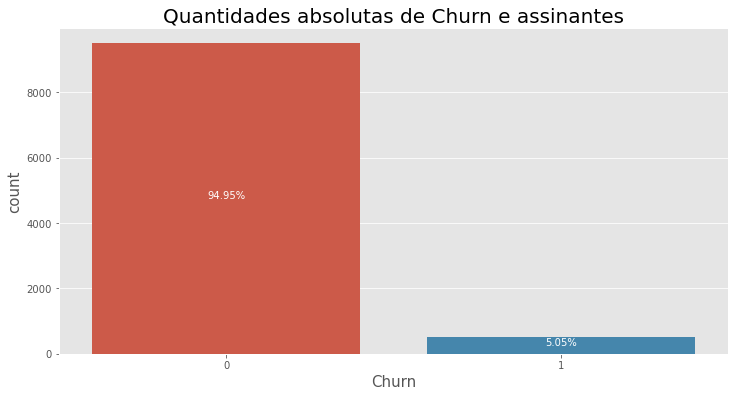

In [15]:
total=len(df_config)
fig, ax = plt.subplots(figsize = (12,6))
g=sns.countplot(data = df_config, x='Churn')
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}%'.format(100*height/total),
            ha="center", color='white')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.title('Quantidades absolutas de Churn e assinantes', fontsize = 20)
plt.savefig('graphs/quantidade_de_churn.png', dpi = 300)
plt.show()

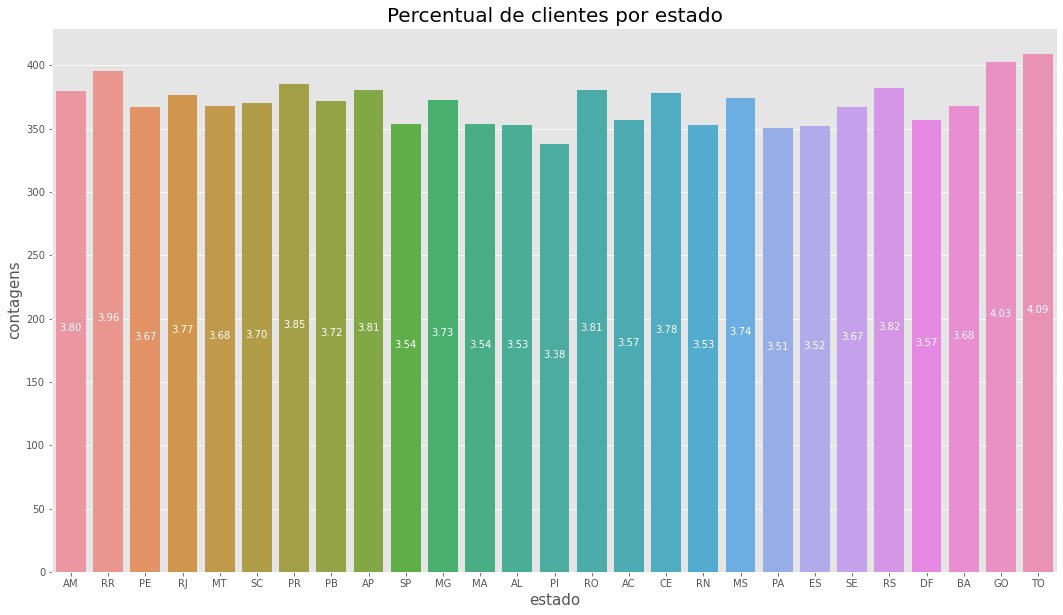

In [16]:
fig, ax = plt.subplots(figsize=(18,10))
g = sns.countplot(x = df_config.estado, ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height/total),
            ha="center", color='white')
plt.xlabel('estado',fontsize = 15)
plt.ylabel('contagens', fontsize = 15)
plt.title('Percentual de clientes por estado', fontsize = 20)
plt.show()

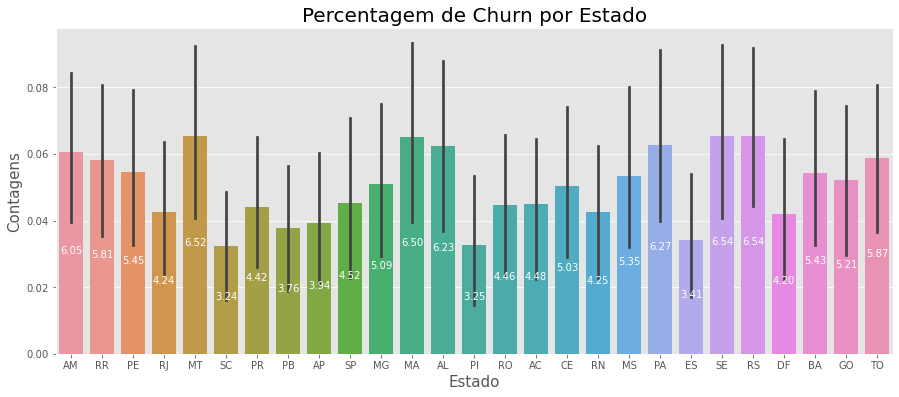

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
g = sns.barplot(x = df_config.estado,y = df_config.Churn , ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height),
            ha="center", color='white')
plt.xlabel('Estado', fontsize = 15)
plt.ylabel('Contagens', fontsize = 15)
plt.title('Percentagem de Churn por Estado', fontsize = 20)
plt.savefig('graphs/percentagem_de_churn_por_estado.png', dpi = 600)
plt.show()

## Podemos observar que os estados AM, MT, MA, AL, PA, SE, RS possuem um percentual de Churn acima de 6%. Assim realizando uma divisão dos estado em 4 categorias baseadas no percentual de Churn

In [18]:
df_churn_6 = df_config.loc[df_config['estado'].isin(['AM','MT','MA','AL','PA','SE','RS'])]
df_churn_5 = df_config.loc[df_config['estado'].isin(['RR','PE','MG','CE','MS','BA','GO','TO'])]
df_churn_4 = df_config.loc[df_config['estado'].isin(['RJ','PR','SP','RO','AC','RN','DF'])]
df_churn_3 = df_config.loc[df_config['estado'].isin(['SC','PB','AP','PI','ES'])]
df_states = [df_churn_6, df_churn_5, df_churn_4, df_churn_3]

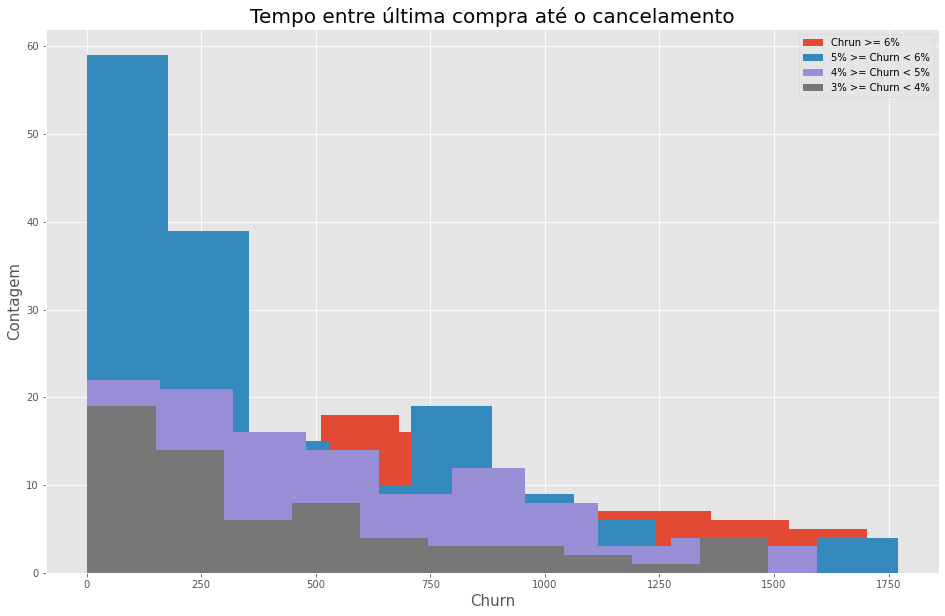

In [19]:
plt.figure(figsize=(16,10))
plt.hist(df_churn_6['permanencia'], label = 'Chrun >= 6%')
plt.hist(df_churn_5['permanencia'], label = '5% >= Churn < 6%')
plt.hist(df_churn_4['permanencia'],label = '4% >= Churn < 5%')
plt.hist(df_churn_3['permanencia'], label = '3% >= Churn < 4%')
plt.legend()
plt.title('Tempo entre última compra até o cancelamento',fontsize = 20)
plt.xlabel('Churn', fontsize = 15)
plt.ylabel('Contagem', fontsize = 15)
plt.show()

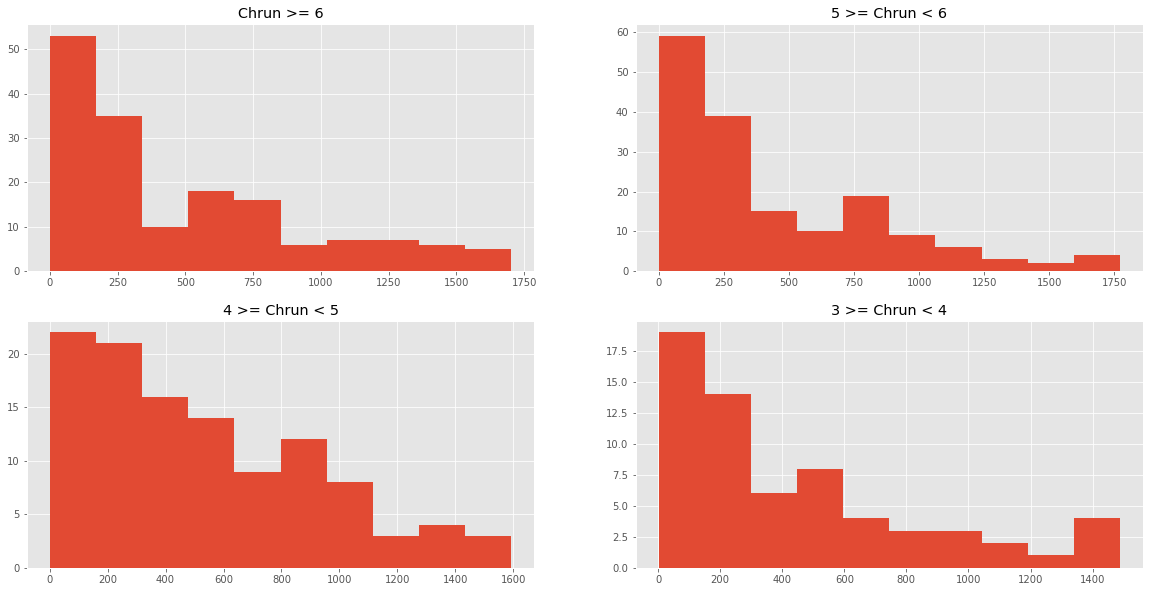

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (20,10))
ax[0,0].hist(df_churn_6['permanencia'], label = 'Chrun >= 6%')
ax[0,0].set_title('Chrun >= 6')
ax[0,1].hist(df_churn_5['permanencia'], label = '5% >= Churn < 6%')
ax[0,1].set_title('5 >= Chrun < 6')
ax[1,0].hist(df_churn_4['permanencia'],label = '4% >= Churn < 5%')
ax[1,0].set_title('4 >= Chrun < 5')
ax[1,1].hist(df_churn_3['permanencia'], label = '3% >= Churn < 4%')
ax[1,1].set_title('3 >= Chrun < 4')
plt.show()

## Observamos que a distribuição do tempo de última compra ao cancelamento se apresenta similar em todos os Churn. Apresentando uma diferença no estado com um percentual de Churn entre 4% a 5%, em que temos clientes que tiveram uma maior permanência.

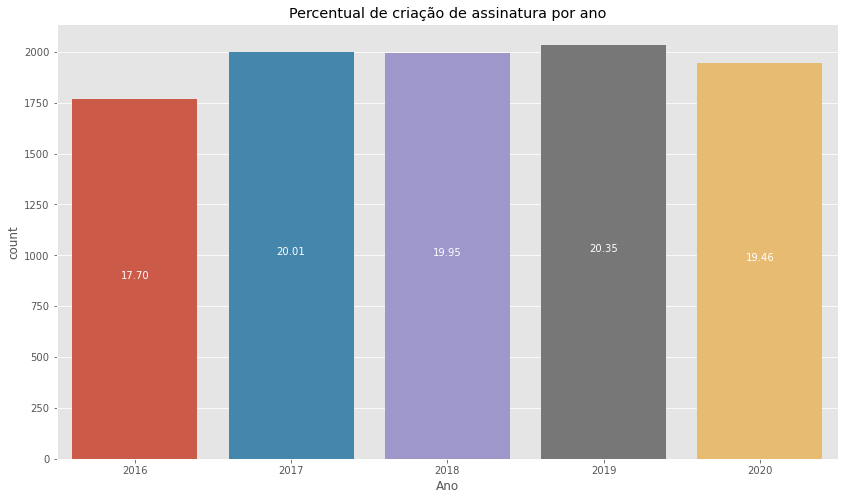

In [21]:
fig, ax = plt.subplots(figsize=(14,8))
g = sns.countplot(x = df_config[df_config.created_at.dt.year != 2021].created_at.dt.year, ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height/total),
            ha="center", color='white')
plt.xlabel('Ano')
plt.title('Percentual de criação de assinatura por ano')
plt.savefig('graphs/percentual_assinaturas_geradas_ano.png')
plt.show()

## Removemos o ano de 2021 pois a estatística é baixa

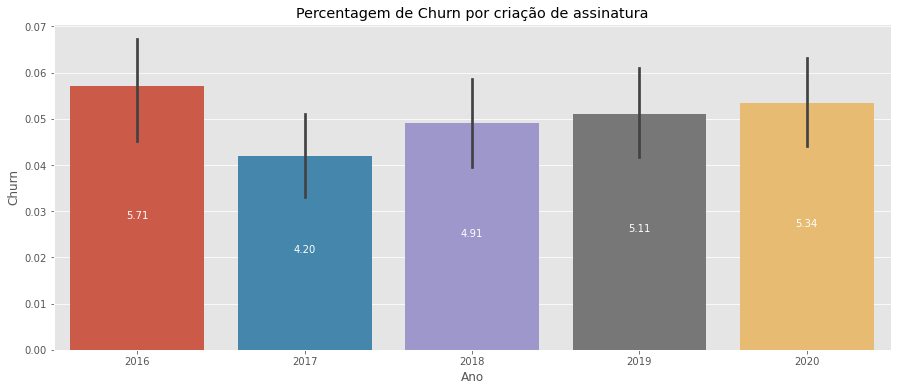

In [22]:
fig, ax = plt.subplots(figsize=(15,6))
g = sns.barplot(x = df_config[df_config.created_at.dt.year != 2021].created_at.dt.year,y = df_config.Churn , ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height),
            ha="center", color='white')
plt.xlabel('Ano')
plt.title('Percentagem de Churn por criação de assinatura')
plt.savefig('percentagem_churn_por_assinatura_ano.png')
plt.show()

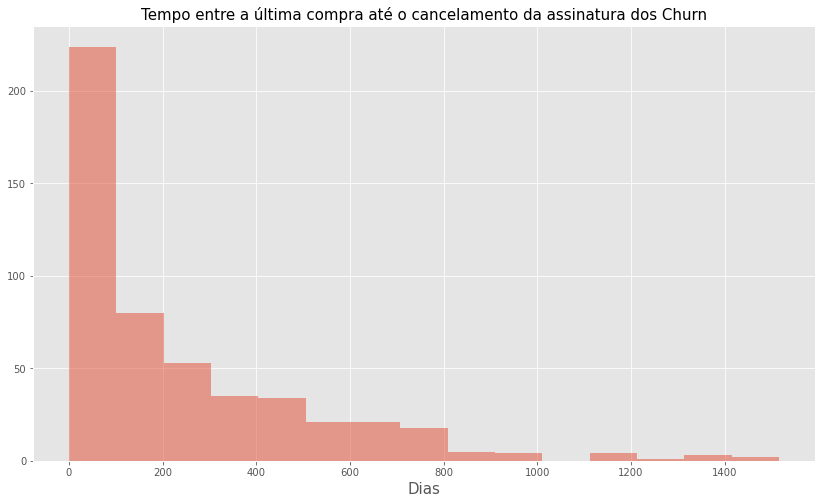

In [50]:
plt.figure(figsize=(14,8))
df_config['ultima_cancelamento'].hist(bins=15, alpha=0.5)
plt.title('Tempo entre a última compra até o cancelamento da assinatura dos Churn',fontsize =15)
plt.xlabel('Dias',fontsize = 15)
plt.savefig('graphs/perido_entre_ultima_compra_cancelamento.png')
plt.show()

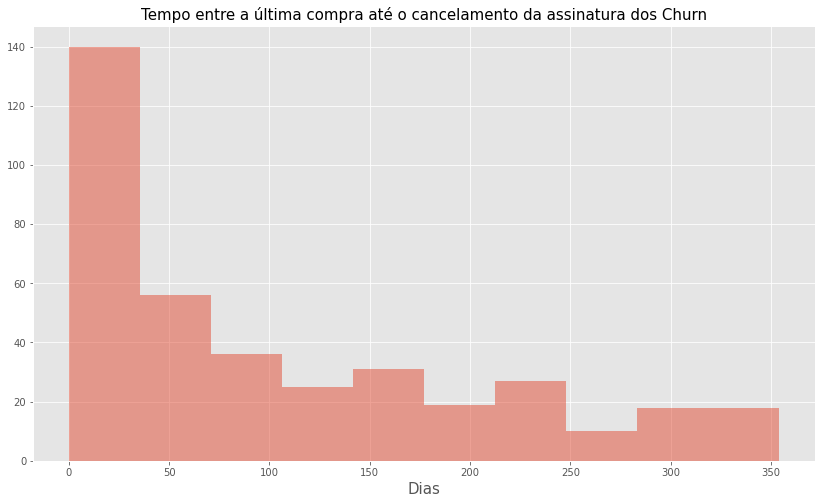

In [49]:
plt.figure(figsize=(14,8))
df_config.loc[df_config['Churn'] == 1].query('ultima_cancelamento < 360.0')['ultima_cancelamento'].hist(alpha = 0.5)
plt.title('Tempo entre a última compra até o cancelamento da assinatura dos Churn',fontsize =15)
plt.xlabel('Dias',fontsize = 15)
#plt.savefig('graphs/perido_entre_ultima_compra_cancelamento.png')
plt.show()

In [52]:
#removendo o canal de marketing nulo
df_mark = df_config[df_config.canal_marketing != 'none']

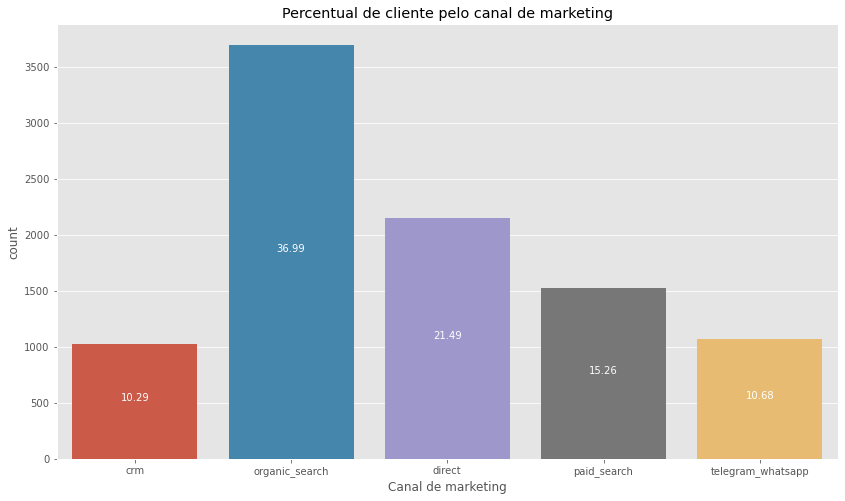

In [54]:
fig, ax = plt.subplots(figsize=(14,8))
g = sns.countplot(x = df_mark.canal_marketing, ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height/total),
            ha="center", color='white')
plt.xlabel('Canal de marketing')
plt.title('Percentual de cliente pelo canal de marketing')
plt.savefig('graphs/percentual_de_cliente_canal_marketing')
plt.show()

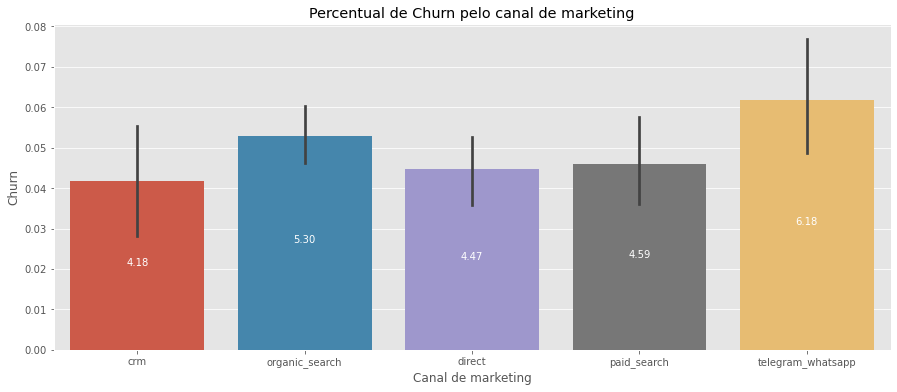

In [55]:
fig, ax = plt.subplots(figsize=(15,6))
g = sns.barplot(x = df_mark.canal_marketing,y = df_mark.Churn , ax=ax)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}'.format(100*height),
            ha="center", color='white')
plt.xlabel('Canal de marketing')
plt.title('Percentual de Churn pelo canal de marketing')
plt.savefig('graphs/percentualde_churn_de_cliente_canal_marketing')
plt.show()

## Perfil de clientes que não buscava um consumo recorrente, somente fazendo a assinatura por um breve período de tempo para aproveitar os descontos e benefícios

# Sugestões de futura a análise e ideias de abordagem do problema

## Podemos futuramente com um melhor conhecimento dos campos realizar uma regressão logística para obtermos um padrão de correlação entre campos

## Para tentar recuperar os clientes em Churn. Podemos ofertar box pet como a box petiko